First, we import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import pipeline
from transformers import  AutoTokenizer
from transformers import AlbertConfig, AlbertModel

import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Look at the data

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
BATCH_SIZE = 64
#NUM_EPOCHS = 11

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

train_val = pd.read_csv("train.csv")
test_val = pd.read_csv("test_no_score.csv")

display(train_val.head(10))

cpu


,title,sentence,score
0,not really sayin anything,this movie is ok but its not teachin anything ...,4.657854
1,Good for the cost.,"This item is cheap, easy to use, and has lots ...",7.531274
2,Great little appliance,I love this chopper as it's the right size for...,9.584762
3,bloated!,there is about 10 minutes of real content in t...,1.016373
4,Long Live Chris!,I'm so glad there are still people out there w...,9.605730
5,New agey nonsense,My wife was given this for free. Her mom died ...,1.133662
6,Dated monotone ...,Being a Cunard aficionado and traveled transat...,2.072175
7,five 3.5 windows? not for me,I'm disappointed with the product description ...,4.271343
8,Do not buy this item!,"Not even worth five bucks. In fact, because I ...",0.148152
9,A superior version of Alice in wonderland,This movie reminded me of a slightly more mani...,8.454322


Initialize the Transformer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("albert/albert-base-v2")

config = AlbertConfig.from_pretrained("albert/albert-base-v2")
albert = AlbertModel.from_pretrained("albert/albert-base-v2")

# Freeze the layers
for param in albert.parameters():
    param.requires_grad = False

Encode the embeddings

In [ ]:
def enc_emb(row):
    title = row.iloc[0]
    content = row.iloc[1]

    with torch.no_grad():
        input_title = torch.tensor(tokenizer.encode(title)).unsqueeze(0)
        output_title = albert(input_title).pooler_output # pooler_output to capture the overall sematic content of the text

        input_content = torch.tensor(tokenizer.encode(content)).unsqueeze(0)
        output_content = albert(input_content).pooler_output # pooler_output to capture the overall sematic content of the text

    return output_title, output_content

In [ ]:
def ext_emb(DataFrame, embedding_size):
    embeddings = torch.empty((2, len(DataFrame), embedding_size), dtype=torch.float32)
    for i, row in tqdm(DataFrame.iterrows(),  total=DataFrame.shape[0], desc=f'Reading {DataFrame.name}'):
        title, content = enc_emb(row)
        
        embeddings[0][i] = title
        embeddings[1][i] = content
    
    return embeddings

In [ ]:
embedding_size = 768

# extract train embeddings
train_val.name = 'Train Data'
train_embeddings = ext_emb(train_val, embedding_size=embedding_size)
np.save('embeddings_ALBERT/train_embeddings.npy', train_embeddings)
print("Train embeddings extracted")

In [ ]:
# extract test embeddings
test_val.name = 'Test Data'
test_embeddings = ext_emb(test_val, embedding_size=embedding_size)
np.save('embeddings_ALBERT/test_embeddings.npy', test_embeddings)
print("Test embeddings extracted")

Load the embeddings

In [3]:
test_embeddings = np.load('embeddings_ALBERT/test_embeddings.npy')
train_embeddings = np.load('embeddings_ALBERT/train_embeddings.npy')

In [5]:
def scale(embedding, scaler):
    titles = embedding[0]
    content = embedding[1]

    titles_scaled = scaler.fit_transform(titles)
    content_scaled = scaler.fit_transform(content)

    embedding_scaled = embedding.copy()

    embedding_scaled[0] = titles_scaled
    embedding_scaled[1] = content_scaled

    return embedding_scaled

In [6]:
scaler = StandardScaler()

test_embeddings_scaled = scale(test_embeddings, scaler)
train_embeddings_scaled = scale(train_embeddings, scaler)

In [8]:
del train_embeddings
del test_embeddings
del scaler

Define custom Dataset

In [9]:
class ReviewDataset(Dataset):
    def __init__(self, data_frame, embeddings, train):
        self.data_frame = data_frame # load the read-in csv file
        self.embeddings = embeddings
        self.train = train # defines if we're working with a train or test dataset (with or without score)

    def __len__(self):
        return len(self.data_frame) # return rows

    def __getitem__(self, index):

        if torch.is_tensor(index):
                index = index.tolist()

        # title
        title = self.embeddings[0][index]

        # content
        content = self.embeddings[1][index]

        if self.train:
            # score
            score = self.data_frame.iloc[index,2]

            #return title, content, score
            sample = {'title': title, 'content': content, 'score': score}

        else:
            #return title, content (without score)
            sample = {'title': title, 'content': content}
        
        return sample

Apply custom dataset and perform train test split on training data

In [10]:
train_dataset_total = ReviewDataset(train_val, embeddings=train_embeddings_scaled, train=True)
test_dataset = ReviewDataset(test_val, embeddings=test_embeddings_scaled, train=False)
train_dataset, valid_dataset = train_test_split(train_dataset_total, random_state=42, test_size=0.2)

del train_val
del test_val

Put data in a DataLoader

In [11]:
num_workers = 0

train_loader_total = DataLoader(dataset=train_dataset_total,
                         batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=num_workers, pin_memory=True)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=num_workers, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=num_workers, pin_memory=True)

Define the MLP

In [23]:
class MyModule(nn.Module):
    def __init__(self,
                num_units_input = 1536,
                num_units = 768,
                nonlin = F.leaky_relu,
                ):
        
        super().__init__()
        self.num_units_input = num_units_input
        self.num_units = num_units
        self.nonlin = nonlin

        # Linear functions
        self.fc1 = nn.Linear(num_units_input, num_units)
        self.fc2 = nn.Linear(num_units, round(num_units/2))
        self.fc3 = nn.Linear(round(num_units/2), round(num_units/3))
        self.fc4 = nn.Linear(round(num_units/3), 1)

        # Activation functions
        self.nonlin = nonlin
        self.sigmoid = nn.Sigmoid()

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(num_units)
        self.bn2 = nn.BatchNorm1d(round(num_units/2))
        self.bn_final = nn.BatchNorm1d(1)

    def forward(self, x):

        x = self.nonlin(self.fc1(x))
        x = self.bn1(x)
        x = self.nonlin(self.fc2(x))
        x = self.bn2(x)
        x = self.nonlin(self.fc3(x))
        x = self.dropout(x)
        x = self.nonlin(self.fc4(x))
        x = self.bn_final(x)
        x = self.sigmoid(x)*10 # to get output between 0 and 10
        x = x.view(-1)
        
        return x


Model selection

In [24]:
model = MyModule().to(DEVICE)

NUM_EPOCHS = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda1)

train_losses = []
valid_losses = []

model.train()
for epoch in range(NUM_EPOCHS):
    model.train()

    # training loop
    running_loss = 0.0

    for sample in train_loader:
        title = sample['title'].to(DEVICE)
        content = sample['content'].to(DEVICE)
        score = sample['score'].to(DEVICE)

        input = torch.cat((title, content), -1)
        optimizer.zero_grad()
        output = model(input)
        
        loss = criterion(output, score.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*input.size(0)
    
    training_loss = running_loss / len(train_loader.dataset)
    train_losses.append(training_loss)

    scheduler.step()

    # validation loop
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for sample in valid_loader:
            title = sample['title'].to(DEVICE)
            content = sample['content'].to(DEVICE)
            score = sample['score'].to(DEVICE)

            input = torch.cat((title, content), -1)
            output = model(input)
            
            loss = criterion(output, score.float())
            valid_loss += loss.item()*input.size(0)
    
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    #scheduler.step()

    print(f'Epoch {epoch+1} \t\t Training Loss: {training_loss} \t Validation Loss: {valid_loss}')

Epoch 1 		 Training Loss: 10.971940054321289 	 Validation Loss: 10.354418711853027
Epoch 2 		 Training Loss: 8.917001056671143 	 Validation Loss: 5.733812867736816
Epoch 3 		 Training Loss: 6.028960964965821 	 Validation Loss: 5.692393262672424
Epoch 4 		 Training Loss: 5.004091248703003 	 Validation Loss: 4.572905363464355
Epoch 5 		 Training Loss: 4.50903265838623 	 Validation Loss: 4.636930767536163
Epoch 6 		 Training Loss: 4.309594402694702 	 Validation Loss: 3.949504180622101
Epoch 7 		 Training Loss: 3.9533838615417483 	 Validation Loss: 3.9443527015686035
Epoch 8 		 Training Loss: 3.8708038444519044 	 Validation Loss: 3.7718184143066407
Epoch 9 		 Training Loss: 3.677022843170166 	 Validation Loss: 4.009313013076782
Epoch 10 		 Training Loss: 3.5171047603607177 	 Validation Loss: 3.813232194519043
Epoch 11 		 Training Loss: 3.374852491378784 	 Validation Loss: 3.6648180053710937
Epoch 12 		 Training Loss: 3.3361472023010252 	 Validation Loss: 3.8338697147369385
Epoch 13 		 Trai

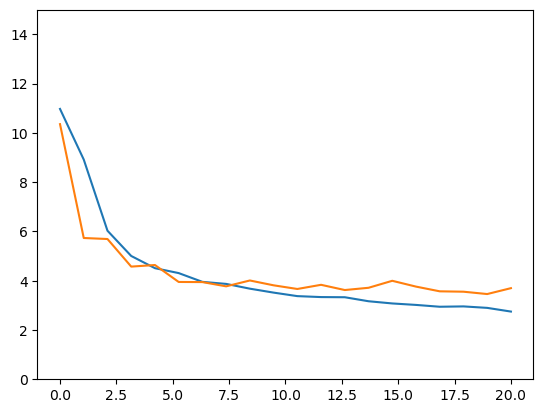

In [25]:
x = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS)

plt.plot(x, train_losses)
plt.plot(x, valid_losses)
plt.ylim(0., 15)

plt.show()

Training loop

In [26]:
model = MyModule().to(DEVICE)

NUM_EPOCHS = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda1)

model.train()
for epoch in range(NUM_EPOCHS):
    model.train()

    running_loss = 0.0

    for sample in train_loader_total:
        title = sample['title'].to(DEVICE)
        content = sample['content'].to(DEVICE)
        score = sample['score'].to(DEVICE)

        input = torch.cat((title, content), -1)
        
        optimizer.zero_grad()
        output = model(input)
        
        loss = criterion(output, score.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*input.size(0)

    training_loss = running_loss / len(train_loader.dataset)
    scheduler.step()
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {training_loss}')

Epoch 1 		 Training Loss: 13.672700457382202
Epoch 2 		 Training Loss: 12.895834921646118
Epoch 3 		 Training Loss: 9.268103957366943
Epoch 4 		 Training Loss: 6.708257639503479
Epoch 5 		 Training Loss: 5.889385396385193
Epoch 6 		 Training Loss: 5.505924179744721
Epoch 7 		 Training Loss: 5.197392390537262
Epoch 8 		 Training Loss: 4.898648763751984
Epoch 9 		 Training Loss: 4.6850445536613465
Epoch 10 		 Training Loss: 4.5987526258468625
Epoch 11 		 Training Loss: 4.570238207817078
Epoch 12 		 Training Loss: 4.30876289434433
Epoch 13 		 Training Loss: 4.213368010139465
Epoch 14 		 Training Loss: 4.140250939893723
Epoch 15 		 Training Loss: 4.017431284523011
Epoch 16 		 Training Loss: 3.9411824847221375
Epoch 17 		 Training Loss: 3.9368967732429505
Epoch 18 		 Training Loss: 3.8351027029037477
Epoch 19 		 Training Loss: 3.7260003231048584
Epoch 20 		 Training Loss: 3.687463657951355


Evaluation Loop

In [27]:
model.eval()

results = []
with torch.no_grad():

    for sample in test_loader:
        title = sample['title'].to(DEVICE)
        content = sample['content'].to(DEVICE)

        input = torch.cat((title, content), -1)
        output = model(input)
                
        results.append(output)

    with open("result.txt", "w") as f:
        for val in np.concatenate(results):
            f.write(f"{val}\n")